## Import Libraries

In [1]:
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from quspin.basis import spinless_fermion_basis_1d
import numpy as np
import matplotlib.pyplot as plt
import itertools
from quspin.tools.evolution import expm_multiply_parallel
plt.rcParams['figure.figsize'] = [10, 8]

## Define Constants/Helpers

In [2]:
N_group = 4
N = 4
N_filled = N // 2
P_neg1 = 1
t = -0.5
g = 1e-3
g_corrected = g / (4 * np.pi ** 2) * N_group ** 2
m = -1
PBC = True

In [3]:
def stringbox(lst, caption):
    return caption + "-" * (100 - len(caption))+"\n" + str(lst) + "\n" + "-" * 100

## Spin Basis Simulation

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


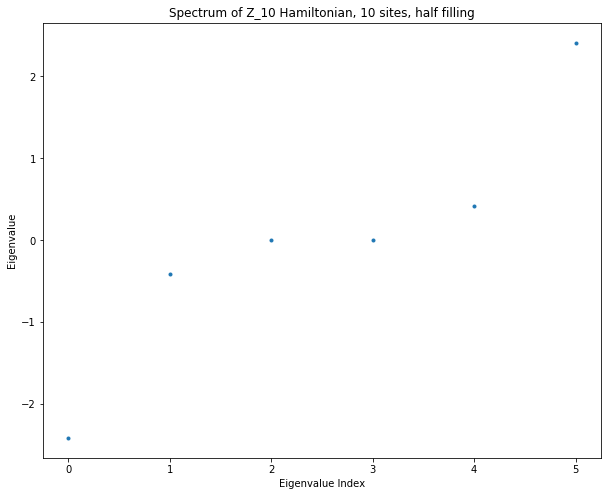

In [4]:
spin_basis = spin_basis_1d(N, pauli=-1, Nup=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
if PBC and N_filled % 2 == 0:
    hop_coupling[-1][0] = -hop_coupling[-1][0]
    hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
def powerset(seq):
    if len(seq) == 1:
        yield seq
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item
def P(n, dag=False):
    i_parity = (-1 if dag else 1)
    phase = np.exp(1j * (1 - n % 2) * np.pi / N_group * i_parity)
    P_coupling = []
    for seq in powerset(list(range(n + 1))):
        seq = list(seq)
        coupling = np.cos(np.pi / N_group)**(n - len(seq) + 1) * (np.sin(np.pi / N_group) * i_parity * 1j)**len(seq)
        coupling *= P_neg1 * -g_corrected * phase
        couple_list = [coupling] + seq
        P_coupling += [["z" * len(seq)] + [[couple_list]]]
    return P_coupling
    
for i in range(N):
    static_terms += P(i, dag=False)
    static_terms += P(i, dag=True)

# This list is annoyingly long
# print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)
H_init = H # Used later in 
spin_eigvals = H.eigvalsh()
plt.plot(spin_eigvals, ".")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.title("Spectrum of Z_10 Hamiltonian, 10 sites, half filling")
plt.show()

## Fermion Basis

Static couplings:-----------------------------------------------------------------------------------
[['+-', [[0.5, 0, 1], [0.5, 1, 2], [0.5, 2, 3], [0.5, 3, 0]]], ['+-', [[0.5, 1, 0], [0.5, 2, 1], [0.5, 3, 2], [0.5, 0, 3]]], ['+-', [[-1, 0, 0], [1, 1, 1], [-1, 2, 2], [1, 3, 3]]], ['z', [[-0.002, 0]]], ['zz', [[-0.004, 0, 1]]], ['zzz', [[0.008, 0, 1, 2]]], ['zzzz', [[0.016, 0, 1, 2, 3]]]]
----------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


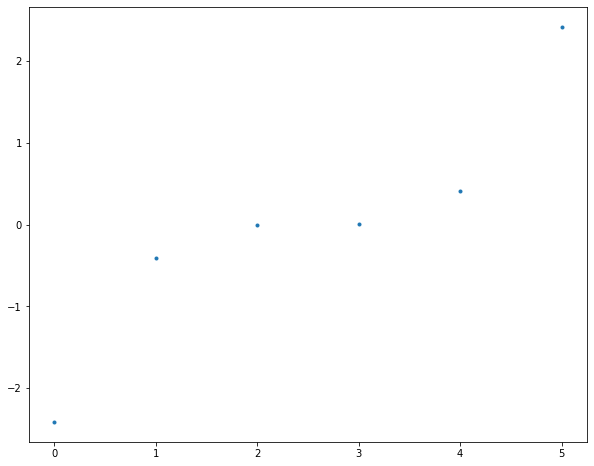

In [5]:
fermion_basis = spinless_fermion_basis_1d(L=N, Nf=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
E_link_parity = lambda x : -1 if (x % 4) < 2 else 1
for i in range(N):
    E_coupling = [P_neg1 * g * E_link_parity(i) * 2 ** (i+1)] + list(range(i+1))
    static_terms += [["z" * (i+1), [E_coupling]]]

print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)
fermion_eigvals = H.eigvalsh()
plt.plot(fermion_eigvals, ".")
plt.show()

## Comparison

In [6]:
mdiff = max(abs(fermion_eigvals - spin_eigvals))
print(stringbox(fermion_eigvals, "Fermion eigenvalues:"))
print(stringbox(spin_eigvals, "Spin eigenvalues:"))
print("Maximum difference between eigenvalues:", mdiff)

Fermion eigenvalues:--------------------------------------------------------------------------------
[-2.41406735e+00 -4.12779583e-01  4.00633577e-08  2.00000000e-03
  4.15072083e-01  2.41777481e+00]
----------------------------------------------------------------------------------------------------
Spin eigenvalues:-----------------------------------------------------------------------------------
[-2.4143033e+00 -4.1497007e-01 -8.1072538e-04 -4.0528097e-04
  4.1369474e-01  2.4127409e+00]
----------------------------------------------------------------------------------------------------
Maximum difference between eigenvalues: 0.005033861727496092


## Real-time Dynamics

In [7]:
### Defining time-evolution hamiltonian
spin_basis = spin_basis_1d(N, pauli=-1, Nup=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
if PBC and N_filled % 2 == 0:
    hop_coupling[-1][0] = -hop_coupling[-1][0]
    hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[-m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
for i in range(N):
    static_terms += P(i, dag=False)
    static_terms += P(i, dag=True)

H = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [8]:
E_init,V_init=H_init.eigsh(k=1,which='SA',maxiter=1e8)
psi_i=V_init[:,0]
psi_i = psi_i.reshape((-1,))
del H_init

In [9]:
T = 8
dt = 0.01

##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
# construct piece-wise constant unitaries
expH = expm_multiply_parallel(H.tocsr(),a=-1j*dt,dtype=dtype_cmplx)
# auxiliary array for memory efficiency
psi=psi_i.copy().astype(np.complex128)
work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
# prepare output
# file_Loschmidt = open(folder_save+'/Loschmidt_rate',"w")
# file_Loschmidt.close
loschmidt = []
for i in range(len(times)):
    if i % (len(times)//10) == 0:
        print("# T = ",times[i])
    Lt[i]=-np.log(np.abs(np.vdot(psi_i,psi)))/N
#     file_Loschmidtfile = open(folder_save+'/Loschmidt_rate',"a")
    print(f"{times[i]}\t {Lt[i]}")#file_Loschmidtfile.write(f"{times[i]}\t {Lt[i]} \n")
    loschmidt += [Lt[i]]
#     file_Loschmidtfile.close()
    expH.dot(psi,work_array=work_array,overwrite_v=True)
# END of time evolution

# T =  0.0
0.0	 -4.668601591274483e-08
0.01	 2.4961749215025686e-05
0.02	 9.999706365926697e-05
0.03	 0.0002250892995986774
0.04	 0.00040028858098537743
0.05	 0.0006256651938555861
0.06	 0.0009013096992938183
0.07	 0.001227333079332414
0.08	 0.0016038669162882538
0.09	 0.0020310636061545134
0.1	 0.0025090966067855876
0.11	 0.0030381607217411016
0.12	 0.003618472420782723
0.13	 0.004250270198155145
0.14	 0.00493381496992766
0.15	 0.005669390511820818
0.16	 0.006457303939106423
0.17	 0.00729788623033676
0.18	 0.008191492796842658
0.19	 0.009138504100131593
0.2	 0.010139326319528682
0.21	 0.01119439207262317
0.22	 0.012304161191327531
0.23	 0.013469121556614462
0.24	 0.014689789995280908
0.25	 0.01596671324239184
0.26	 0.017300468973391457
0.27	 0.01869166691022811
0.28	 0.02014095000623779
0.29	 0.02164899571495751
0.3	 0.023216517348516076
0.31	 0.02484426553176317
0.32	 0.026533029758867673
0.33	 0.02828364005973718
0.34	 0.030096968784301716
0.35000000000000003	 0.03197393251345708
0.

Text(0.5, 1.0, 'Non-analycities in Lohscmidt Echo Rate')

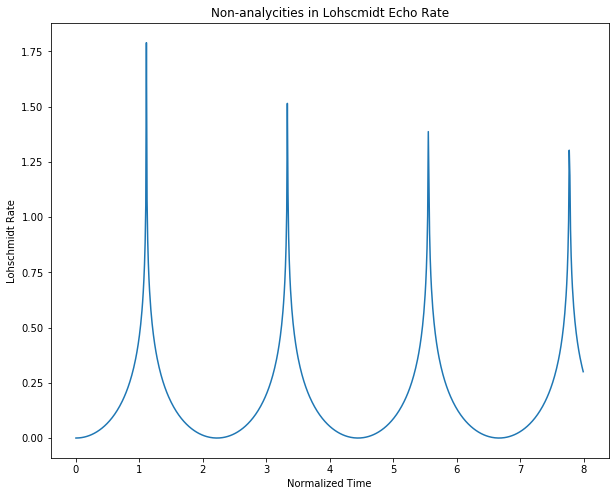

In [10]:
plt.plot(times, loschmidt)
plt.xlabel("Normalized Time")
plt.ylabel("Lohschmidt Rate")
plt.title("Non-analycities in Lohscmidt Echo Rate")

## Niklas Code (TODO: FIX BASIS)

In [ ]:
psi_init = psi_i.copy().astype(np.complex128)

# apply c_0 & c_1 to initial state
c0_static = [["-",[[1.0,0]]]]
c0 = quantum_LinearOperator(c0_static,basis=basis_full,dtype=np.float64,check_herm=False,check_pcon=False)
psi_init_c0 = np.transpose(P_Nhalfminus1).dot(c0.dot(P_Nhalf.dot(psi_init)))
# del c0
c1_static = [["-",[[1.0,1]]]]
c1 = quantum_LinearOperator(c1_static,basis=basis_full,dtype=np.float64,check_herm=False,check_pcon=False)
psi_init_c1 = np.transpose(P_Nhalfminus1).dot(c1.dot(P_Nhalf.dot(psi_init)))
# del c1
H_quenched = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis_m1, dtype=np.float64)
# evolving in time (forward)
psi_t_c0 = H_quenched.evolve(psi_init_c0,0,times)#,solver_name='dopri5',atol=1e-16,rtol=1e-16)
psi_t_c1 = H_quenched.evolve(psi_init_c1,0,times)#,solver_name='dopri5',atol=1e-16,rtol=1e-16)
# del H_quenched
#print(np.shape(psi_t))
H_quenched_r =  -hamiltonian(static_terms,dynamic_terms,basis=fermion_basis,dtype=np.float64)
Gnt_all = []
for n in range(N):
    Gnt = np.zeros(len(times),dtype=np.complex128)
    # apply c_n^\dagger to evolved states
    psi_t_cn = []
    cn_static = [["+",[[1.0,n]]]]
    cn = quantum_LinearOperator(cn_static,basis=basis_full,dtype=np.float64,check_herm=False,check_pcon=False)
    for t in range(len(times)):
        if n%2 == 0:
            psi_t_cn.append( np.transpose(P_Nhalf).dot(cn.dot(P_Nhalfminus1.dot(psi_t_c0[:,t]))) )
        if n%2 == 1:
            psi_t_cn.append( np.transpose(P_Nhalf).dot(cn.dot(P_Nhalfminus1.dot(psi_t_c1[:,t]))) )
    del cn
    psi_t_cn = np.array(psi_t_cn)
    #print(np.shape(psi_t_cn))
    # evolve backwards in time & get the correlators
    for t in range(len(times)):
        psi_t_cn[t,:] = H_quenched_r.evolve(psi_t_cn[t,:],0,times[t])
        Gnt[t] = np.vdot(psi_init,psi_t_cn[t,:])
    print('N'+str(N)+'_Gt_n'+str(n)+'_done')
    Gnt_all.append(Gnt)
Gnt_all = np.array(Gnt_all)
#np.save(folder_save+'/TwoTime_correlators',Gnt_all)
Nt = len(times)
Gnt_half = np.zeros((N//2,Nt),dtype=np.complex128)
for n in range(N//2):
    Gnt_half[n,:] = Gnt_all[2*n,:] + Gnt_all[2*n+1,:]
Gkt = np.fft.fft(Gnt_half,axis=0)

#Plot FFT
correlatorfft = Gkt.T
step_x = 1 # step between consecutive labels
x_positions = np.arange(0,N//2,step_x) # pixel count at label position
x_labels = np.arange(N//4-N//2+1, N//4+1) # labels you want to see
plt.xticks(x_positions, x_labels)
y_tickcount = 10 # How many labels on y axis
y_positions = np.arange(0,int(T/dt), int((T/dt)/y_tickcount)) # pixel count at label position
y_labels = np.round(np.linspace(0,abs(T*m),y_tickcount), 3) # labels you want to see
plt.yticks(y_positions, y_labels)
plt.imshow(np.arctan2(np.imag(correlatorfft), np.real(correlatorfft)), aspect='auto', origin='lower')
plt.show()

Lt_from_Gkt = -np.sum(np.log(np.abs(Gkt)),axis=0)/N
Nk, Nt = np.shape(Gkt)
dphi_kt_k = np.zeros((Nk,Nt-1))
dphi_kt_t = np.zeros((Nk,Nt-1))
Fkt = np.zeros((Nk,Nt-2))
for k in range(Nk):
    for t in range(Nt-1):
        dphi_kt_k[k,t] = np.angle(Gkt[(k+1)%Nk,t]/Gkt[k,t])
        dphi_kt_t[k,t] = np.angle(Gkt[k,t+1]/Gkt[k,t])
for k in range(Nk):
    for t in range(Nt-2):
        Fkt[k,t] = (dphi_kt_k[k,t] + dphi_kt_t[(k+1)%Nk,t]) - (dphi_kt_k[k,t+1] + dphi_kt_t[k,t])
Fkt_ksum1 = np.zeros(Nt-2)
Fkt_ksum2 = np.zeros(Nt-2)
for k in range(Nk//2):
    Fkt_ksum1 += Fkt[(k),:]/2/np.pi
    Fkt_ksum2 += Fkt[(k+Nk//2),:]/2/np.pi
n1 = []
n2 = []
for t in range(Nt-2):
    ntau1 = 0
    ntau2 = 0
    for tau in range(0,t):
        ntau1 += Fkt_ksum1[tau]
        ntau2 += Fkt_ksum2[tau]
    n1.append(ntau1)
    n2.append(ntau2)
n1 = np.array(n1)
n2 = np.array(n2)